In [173]:
import pandas as pd
import numpy as np
import string
import nltk
import re

pd.set_option('display.max_colwidth', 100)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/clean/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [174]:
columns = ['type', 'text', '1', '2', '3']

messages = pd.read_csv('spam.csv', encoding='latin-1', names=columns, header=0)
messages.head()

,type,text,1,2,3
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


## Data Analysis and Preparation

Let's look at the last 3 columns.

In [175]:
messages.notnull().sum()

type    5572
text    5572
1         50
2         12
3          6
dtype: int64

In [176]:

messages['3'].loc[messages['3'].notnull()]

281                                just Keep-in-touch\" gdeve.."
1038                                                     GNT:-)"
2255     Never comfort me with a lie\" gud ni8 and sweet dreams"
3525                         CALL 2MWEN IM BK FRMCLOUD 9! J X\""
4668             one day these two will become FREINDS FOREVER!"
5048                                                     GNT:-)"
Name: 3, dtype: object

Well, it seems that the last they also have a small part of the content of the messages. We can put them together or just ignore them due to their almost irrelevant content. Now, let's see the percentage of hams and spams.

In [177]:
messages = messages.iloc[:, :2]
messages['type'].value_counts(normalize=True)


ham     0.865937
spam    0.134063
Name: type, dtype: float64

Now, it's necessary to prepare the data for training by removing punctuation, stopwords and tokenizing.

In [178]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
stopwords = nltk.corpus.stopwords.words('english')
def clean_text(text):
    tokens = tokenizer.tokenize(text.lower())
    clean_text = [word for word in tokens if word not in stopwords]
    return clean_text

messages['text_clean'] = messages['text'].apply(lambda x: clean_text(x))

***
## Vectorize Text Using TF-IDF

*TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.*

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(analyzer=clean_text)
x_tfidf = tfidf_vector.fit_transform(messages['text'])
tfidf_vector.vocabulary_['man']

4812

In [204]:
x_features = pd.DataFrame(x_tfidf.toarray())
x_features.head()

,0,1,2,3,4,5,6,7,8,9,...,8559,8560,8561,8562,8563,8564,8565,8566,8567,8568
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***
## Fit a Random Forest Classifier
*Random Forest is an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees.*

In [205]:
X_train, X_test, y_train, y_test = train_test_split(x_features, messages['type'], test_size=0.2)

In [206]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)

In [207]:
y_pred = rf_model.predict(X_test)

In [208]:
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
print('Precision: {}% | Recall: {}%'.format(round(precision, 2)*100, round(recall, 2)*100))

Precision: 100.0% | Recall: 91.0%


***
## Fit a Word2Vec Model
*The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.*

In [127]:
import gensim

X_train, X_test, y_train, y_test = train_test_split(messages['text_clean'], messages['type'], test_size=0.2)

Let's check what words are most associated with 'man'.

In [126]:
w2v_model = gensim.models.Word2Vec(X_train, size=100, window=5, min_count=2)
w2v_model.wv.most_similar('man')

[('like', 0.9997860193252563),
 ('u', 0.9997831583023071),
 ('know', 0.9997776746749878),
 ('4', 0.9997661113739014),
 ('ur', 0.9997653961181641),
 ('get', 0.999765157699585),
 ('life', 0.9997643828392029),
 ('3', 0.9997639656066895),
 ('good', 0.9997610449790955),
 ('c', 0.9997603893280029)]

In [117]:
w2v_vector = np.array([np.array([w2v_model.wv[i] for i in ls if i in w2v_model.wv.index2word]) for ls in X_test])

<ipython-input-117-c6a49d766d4c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  w2v_vector = np.array([np.array([w2v_model.wv[i] for i in ls if i in w2v_model.wv.index2word]) for ls in X_test])


Each text message need to have a equal number of words and vectors. Aditionally, the model needs a constant number of features, otherwise it will thrown an error. This way, we'll calculate the element wise average within each text message, resulting in a single vector which represents all the messages.

In [125]:
w2v_vector_avg = []
for vector in w2v_vector:
    if len(vector)!=0:
        w2v_vector_avg.append(vector.mean(axis=0))
    else:
        w2v_vector_avg.append(np.zeros(100))

***
## Fit a Doc2Vec Model
*The goal of doc2vec is to create a numeric representation of a document, regardless of its length. Instead of creating a vector for each word, this technique will create a vector for each document, or collection of text.*

In [134]:
tagged_docs = [gensim.models.doc2vec.TaggedDocument(v, [i]) for i, v in enumerate(X_train)]
tagged_docs[:2]

[TaggedDocument(words=['best', 'watch', 'say', 'cause', 'get', 'drunk', 'motherfucker'], tags=[0]),
 TaggedDocument(words=['still', 'chance', 'search', 'hard', 'get', 'let', 'try'], tags=[1])]

Finally the cool part, let's train the model and try to infer a list of words in a 'document sense' with a sentence doesn't included in the messages.

In [136]:
d2v_model = gensim.models.Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=2)
d2v_model.infer_vector(['nlp', 'is', 'cool'])

array([-0.00803264,  0.0045521 , -0.0053818 , -0.00048776,  0.0038965 ,
        0.00559126,  0.00564641,  0.00417632,  0.00111376, -0.00051102,
       -0.00178387,  0.00078605, -0.00831483,  0.00561165,  0.01179282,
        0.00445264,  0.00621219, -0.00526336, -0.00622454, -0.00310192,
        0.00491273, -0.00233007,  0.0113351 , -0.00229278,  0.00528412,
        0.00120426,  0.00522305,  0.00746995,  0.00017922,  0.01313468,
        0.00465168,  0.01031378, -0.00370179,  0.00207035, -0.00168964,
       -0.00799371,  0.00892476,  0.00305087, -0.00924057,  0.00399388,
        0.00240374,  0.00179327,  0.00358433, -0.0093256 , -0.00315124,
        0.00613956,  0.00353327,  0.0020589 , -0.00574675, -0.00232404,
       -0.00639667,  0.00312089, -0.00452767,  0.00239819, -0.00143032,
        0.00079102, -0.0046148 ,  0.00205999, -0.00616102,  0.00229503,
        0.0058542 ,  0.00449395,  0.00116111, -0.01102677,  0.00282975,
        0.00028488,  0.00048142, -0.00137886,  0.00985014, -0.00

***
## Fit a Recurrent Neural Network]
*A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence.*

In [144]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# spam might be converted to numeric
labels = np.where(messages['type']=='spam', 1, 0)
X_train, X_test, y_train, y_test = train_test_split(messages['text'], labels, test_size=0.2)

It's necessary to tokenize and assign a index to each unique word of our text. After, we a create a new text sequence using only the words index. 

In [145]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [146]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [147]:
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

Time to fit the model :)

In [152]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

In [153]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

Finally, our sequential RNN model.

In [168]:
model = Sequential()

model.add(Embedding(len(tokenizer.index_word) + 1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          255136    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 264,545
Trainable params: 264,545
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m])

In [170]:
history = model.fit(X_train_seq_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 4s 18ms/step - loss: 0.4133 - accuracy: 0.8666 - precision_m: 0.1866 - recall_m: 0.1442 - val_loss: 0.0841 - val_accuracy: 0.9865 - val_precision_m: 0.9679 - val_recall_m: 0.9056
Epoch 2/10
140/140 [==============================] - 2s 15ms/step - loss: 0.0424 - accuracy: 0.9905 - precision_m: 0.9888 - recall_m: 0.9392 - val_loss: 0.0572 - val_accuracy: 0.9848 - val_precision_m: 0.9714 - val_recall_m: 0.8835
Epoch 3/10
140/140 [==============================] - 2s 15ms/step - loss: 0.0101 - accuracy: 0.9981 - precision_m: 0.9958 - recall_m: 0.9929 - val_loss: 0.0712 - val_accuracy: 0.9839 - val_precision_m: 0.9571 - val_recall_m: 0.8821
Epoch 4/10
140/140 [==============================] - 2s 16ms/step - loss: 0.0052 - accuracy: 0.9983 - precision_m: 0.9912 - recall_m: 0.9837 - val_loss: 0.0830 - val_accuracy: 0.9848 - val_precision_m: 0.9714 - val_recall_m: 0.8821
Epoch 5/10
140/140 [==============================] - 2s 15ms/step -

Let's create a visualization of the accuracy, precision and recall of RNN the model by epoch.

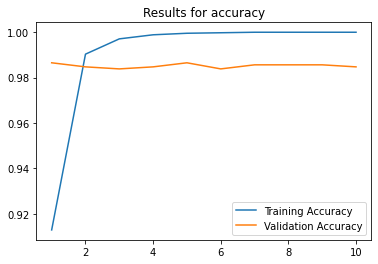

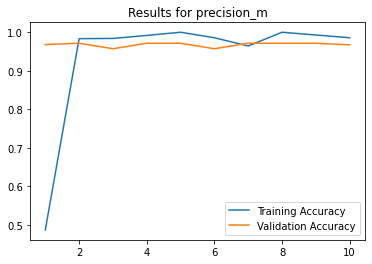

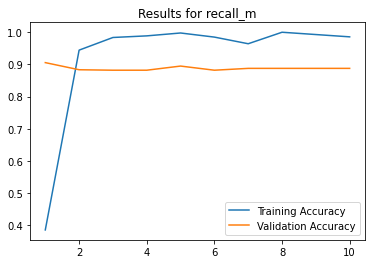

In [171]:
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()